# Завдання на використання SQL в Python

1.Встановіть бібліотеку `mysql-connector-python` через pip aбо через conda.

In [3]:
!pip install mysql-connector-python

2.В змінній `con` створіть підключення до бази даних employees за аналогією того, як це робилось в лекції:

In [6]:
! conda list | grep mysql-connector-python

mysql-connector-python    9.1.0                    pypi_0    pypi


In [70]:
import mysql.connector
from mysql.connector.connection import MySQLConnection
import datetime

In [345]:
con = mysql.connector.connect(user='user1', password='7oygWy6P',
                              host='3.68.62.36',
                              database='employees')

3.Виберіть максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`. Аби отримати результати в кінці, виконайте `cursor.fetchall()`.

In [72]:
cursor = con.cursor()

In [74]:
sql = """
    SELECT MIN(hire_date) AS min_hire_date, MAX(hire_date) AS max_hire_date
    FROM employees;
"""


In [76]:

cursor.execute(sql)
cursor.fetchall()

[(datetime.date(1985, 1, 1), datetime.date(2000, 1, 28))]

Очікуваний результат:  
    `[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]`

4.Давайте зберемо інформацію про останню ЗП кожного співробіткника в базі. З використанням `con.cursor()` виберіть з таблиці `salaries` для кожного співробітника його номер, останню в базі даних (тобто ту, що відповідає найновішій `to_date`) ЗП, та значення `from_date`, `to_date` для цієї ЗП.

Результати запишіть у pandas DataFrame, який збережіть у змінну `res`. Як взяти з курсора назви колонок - вже наведено. На екран виведіть назви колонок в змінній `res`, розмір цього датафрейму та перші 3 записи в ньому.

УВАГА! Зверніть увагу, що ЗП може оновлюватись протягом одного дня, тобто є випадки, коли апдейт ЗП був в певний день, скажімо 2001-01-01 і потім стався ще один апдейт ЗП цьому співробітнику цього самого дня. Запит має це враховувати.
Також, теоретично ЗП може бути зменшена. Тож, брати дату з максимальною ЗП буде неправильно з точки зору бізнес логіки. Треба саме останнє історичне значення ЗП кожного співробітника.

In [78]:
import pandas as pd

In [327]:
cursor = con.cursor()

# SQL-запит для отримання останньої ЗП кожного співробітника
sql2 = """
    SELECT 
        emp_no,
        salary,
        from_date,
        to_date
    FROM 
        salaries 
    WHERE 
        (emp_no, to_date) IN (
            SELECT emp_no, MAX(to_date)
            FROM salaries
            GROUP BY emp_no
        );
"""



In [329]:
# Виконання запиту
cursor.execute(sql2)

columns = [desc[0] for desc in cursor.description]
results = cursor.fetchall()  # Зберігаємо результати в змінну, бо якщо зараз викликати fetchall - то дани очистяться і виведе пустий результат.

# Формування DataFrame
res = pd.DataFrame(results, columns=columns)

# Виведення результатів
#res


In [143]:
field_names = [i[0] for i in cursor.description]

Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1lNvzbAebtkj3C2v-I5AE6HkMH8MTI1kA)

5.В утвореній вибірці в змінній `res` скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? Увага! Для виконання цього завдання важливо розуміти, який тип даних у значень колонки `to_date`. Зʼясуйте це, і потім напишіть фільтр для виводу потрібного результату.

In [312]:
res['to_date'].dtype


dtype('O')

Якщо dtype колонки to_date — dtype('O'), це означає, що колонка має тип object. У більшості випадків це текстовий формат. Для коректної роботи з датами в цій колонці потрібно конвертувати її до формату datetime.

In [330]:
res['to_date'] = pd.to_datetime(res['to_date'], errors='coerce') #Без errors='coerce' виконання кодуможе зупинитися, якщо є некоректні значення.


In [333]:
res['to_date'].dtype #dtype('<M8[ns]') означає, що дані в колонці мають тип datetime64[ns] у Pandas.

dtype('<M8[ns]')

In [335]:
сount_9999 = (res['to_date'] == pd.Timestamp('9999-01-01')).sum()
count_other = (res['to_date'] != pd.Timestamp('9999-01-01')).sum()


In [297]:

print(f"Кількість значень to_date ≠ 9999-01-01: {count_other}")

Кількість значень to_date ≠ 9999-01-01: 300180


In [251]:
print(f"Кількість значень to_date = 9999-01-01: {count_9999}")

NameError: name 'count_9999' is not defined

6.Виведіть візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. Обовʼязково підпишіть графік і вісі.

Ці три завдання - приклад, як нам може бути зручно витягнути дані з бази певним запитом, а потім використати витягнуту вибірку у Python для подальшого аналізу.

In [359]:
current_employees = res[res['to_date'] != pd.Timestamp('9999-01-01')]


current_employees = res[res['to_date'] == pd.Timestamp('9999-01-01')]
Такий рядок дає пусту гістограму, а якщо я обираю не дорівнює, тобто != - то все працює, можете підказати де тут у мене помилка?

In [363]:
type(current_employees)

pandas.core.frame.DataFrame

In [365]:
print(current_employees.shape[0])

300180


In [185]:
import matplotlib.pyplot as plt

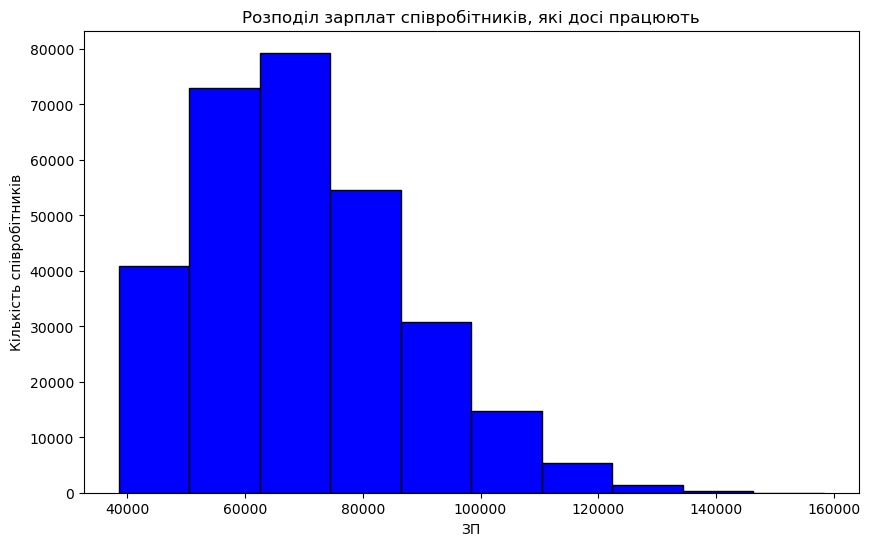

In [367]:
plt.figure(figsize=(10, 6))
plt.hist(current_employees['salary'], color='blue', edgecolor='black')
plt.title('Розподіл зарплат співробітників, які досі працюють')
plt.xlabel('ЗП')
plt.ylabel('Кількість співробітників')
plt.show();

Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1j8MHLC1E0revbQLM9B0UJs6tVEgoWhmK)

НЕ ЗАБУВАЄМО ЗАКРИТИ ПІДКЛЮЧЕННЯ ДО БАЗИ :)

In [370]:
con.close()